In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pywt

import warnings
warnings.filterwarnings("ignore")

# Загрузка EDF файла

In [2]:
raw = mne.io.read_raw_edf("eeg10.edf", preload=True)
raw.info

Extracting EDF parameters from /home/gadzhiev.vazhid/study/platf/task4/eeg10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1389311  =      0.000 ...  5426.996 secs...


<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1-Ref, EEG Fp2-Ref, EEG F3-Ref, EEG F4-Ref, EEG F7-Ref, ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2011-11-11 11:11:11 UTC
 nchan: 21
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: >
>

# Построение графика ЭЭГ во время приступа

In [3]:
# Получаем временные метки
data, times = raw.get_data(return_times=True)
sfreq = raw.info['sfreq']  # частота дискретизации в Гц
print(f"Форма данных: {data.shape}, Частота дискретизации: {sfreq} Гц")

Форма данных: (21, 1389312), Частота дискретизации: 256.0 Гц


In [4]:
# Диапазон приступа 5140-5263
seizure_start = np.where(times > (5140-100))[0][0]
seizure_end = np.where(times > (5263+100))[0][0]
t = times[seizure_start:seizure_end]

Начало приступа: 5040.00390625, Длительность приступа: 323.0
Using matplotlib as 2D backend.


<Figure size 1500x800 with 0 Axes>

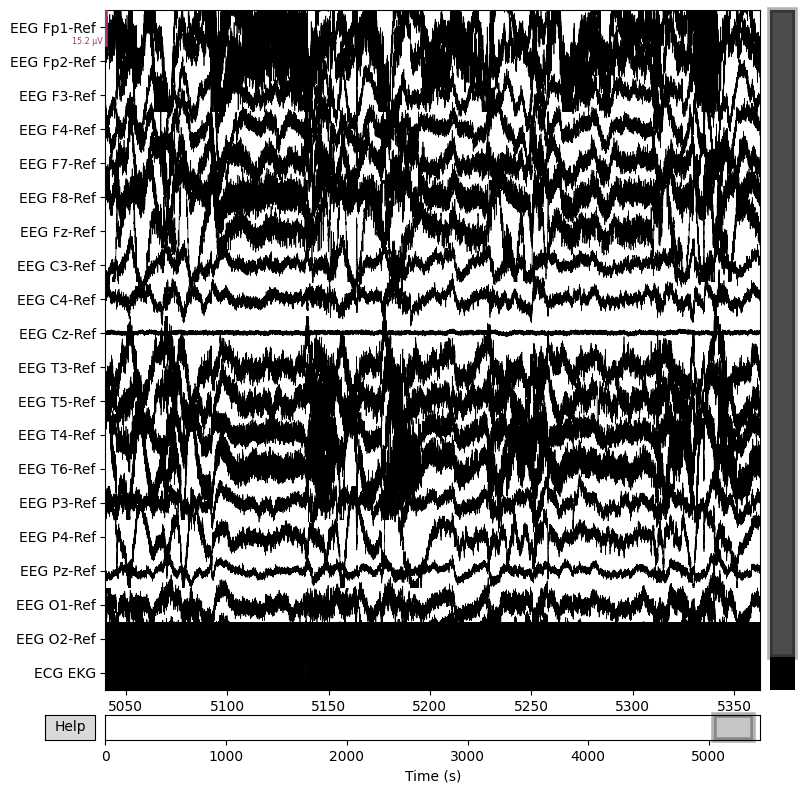

In [5]:
start = seizure_start / sfreq
duration = (seizure_end - seizure_start) / sfreq  # Длительность для отображения в секундах

print(f"Начало приступа: {start}, Длительность приступа: {duration}")

plt.figure(figsize=(15, 8))
raw.plot(start=start, duration=duration, 
         scalings='auto', show=False)
plt.show()

# Усреднение всех каналов ЭЭГ

In [6]:
eeg_data = raw.get_data(picks='eeg')  # Получение только каналов ЭЭГ (исключая ЭКГ, дыхание и т.д.)
average_eeg = np.mean(eeg_data, axis=0)  # Усреднение по всем каналам

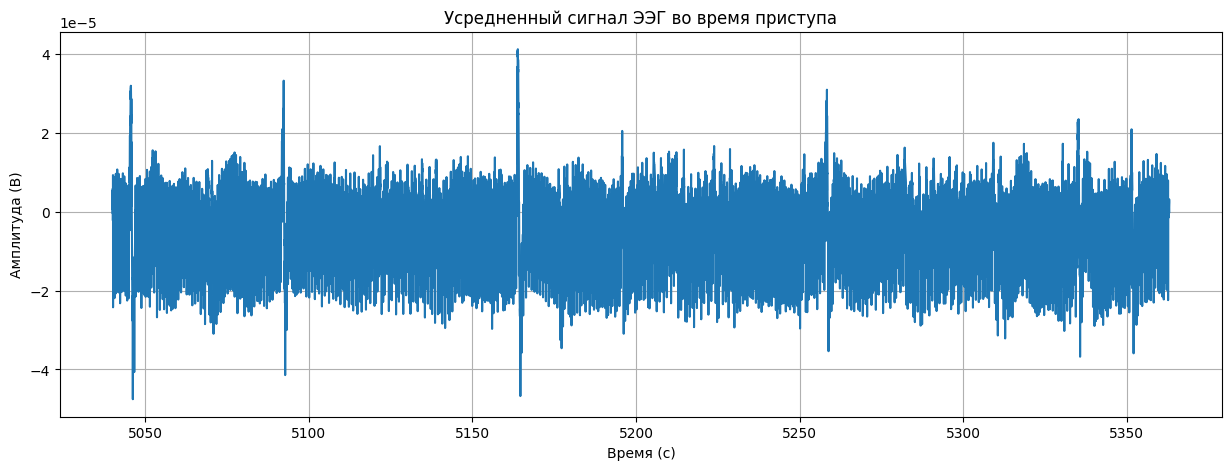

In [7]:
plt.figure(figsize=(15, 5))
# Plot the seizure segment
plt.plot(times[seizure_start:seizure_end], average_eeg[seizure_start:seizure_end])
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда (В)')
plt.title('Усредненный сигнал ЭЭГ во время приступа')
plt.grid(True)
plt.show()

# Фильтрация сигнала для удаления частот выше 60 Гц

In [8]:
# Создание фильтра Баттерворта нижних частот
nyquist = 0.5 * sfreq
cutoff = 60.0
b, a = signal.butter(4, cutoff/nyquist, btype='low')

# Применение фильтра
filtered_eeg = signal.filtfilt(b, a, average_eeg)

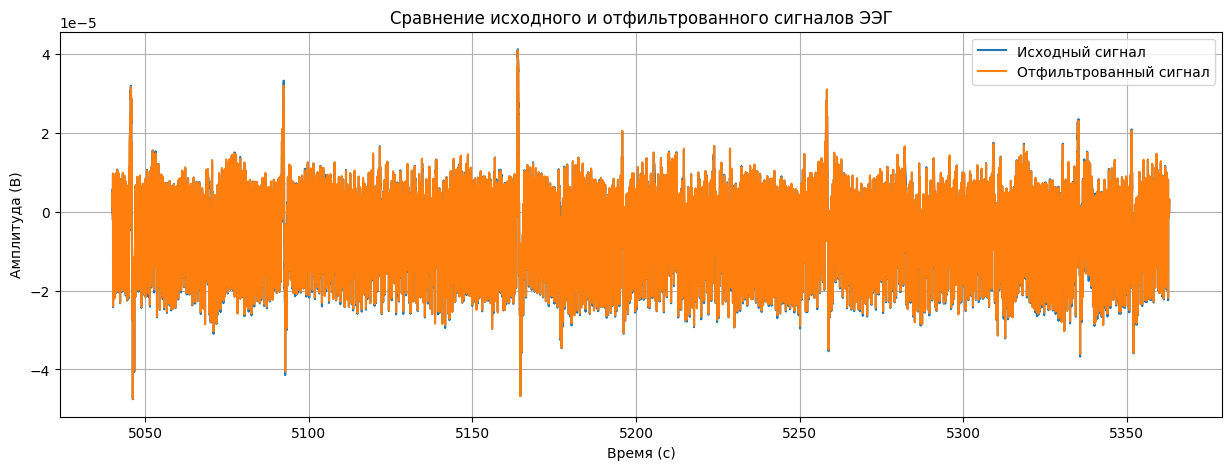

In [9]:
# Построение графиков исходного и отфильтрованного сигналов для сравнения
plt.figure(figsize=(15, 5))
plt.plot(times[seizure_start:seizure_end], average_eeg[seizure_start:seizure_end], label='Исходный сигнал')
plt.plot(times[seizure_start:seizure_end], filtered_eeg[seizure_start:seizure_end], label='Отфильтрованный сигнал')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда (В)')
plt.title('Сравнение исходного и отфильтрованного сигналов ЭЭГ')
plt.legend()
plt.grid(True)
plt.show()

#  Построение спектрограммы отфильтрованного сигнала

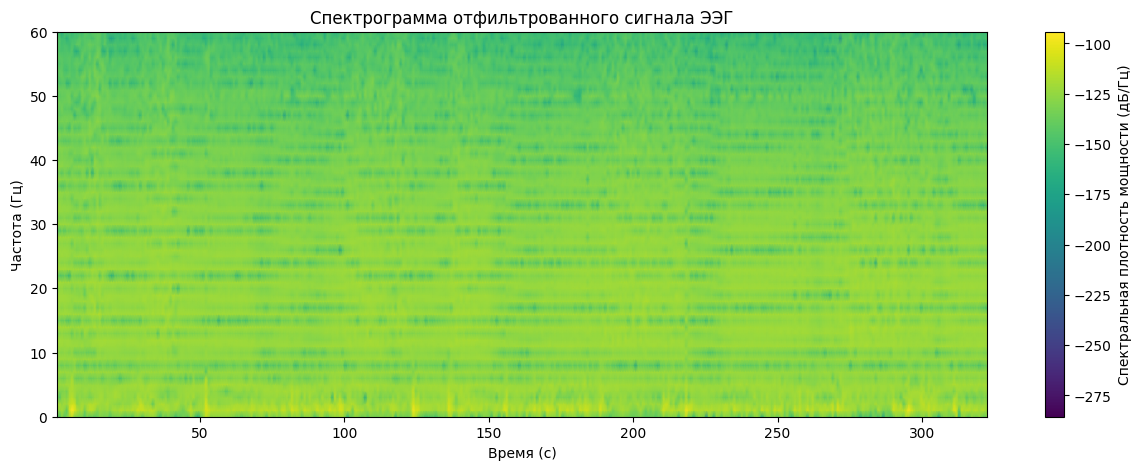

In [10]:
plt.figure(figsize=(15, 5))
f, t, Sxx = signal.spectrogram(filtered_eeg[seizure_start:seizure_end], fs=sfreq, nperseg=256)
plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud')
plt.colorbar(label='Спектральная плотность мощности (дБ/Гц)')
plt.ylabel('Частота (Гц)')
plt.xlabel('Время (с)')
plt.title('Спектрограмма отфильтрованного сигнала ЭЭГ')
plt.ylim(0, 60)  # Фокус на частотах до 60 Гц
plt.show()

# Построение вейвлет-преобразования (скалограммы) отфильтрованного сигнала


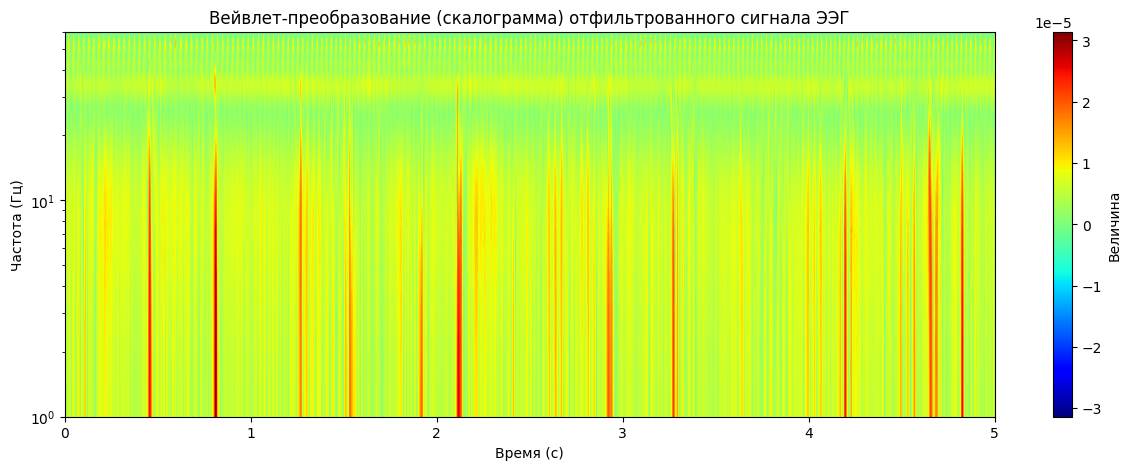

In [11]:
# Выбор сегмента данных для более четкой визуализации
segment = filtered_eeg[seizure_start:seizure_end]  # Первые 5 секунд

# Параметры вейвлета
wavelet = 'cmor1.5-1.0'  # Комплексный вейвлет Морле
scales = np.arange(1, 128)  # Диапазон масштабов

# Выполнение непрерывного вейвлет-преобразования
coefficients, frequencies = pywt.cwt(segment, scales, wavelet, sampling_period=1/sfreq)

# Построение скалограммы
plt.figure(figsize=(15, 5))
plt.imshow(np.abs(coefficients), extent=[0, 5, 1, 60], 
           cmap='jet', aspect='auto', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())
plt.colorbar(label='Величина')
plt.xlabel('Время (с)')
plt.ylabel('Частота (Гц)')
plt.title('Вейвлет-преобразование (скалограмма) отфильтрованного сигнала ЭЭГ')
plt.yscale('log')
plt.ylim(1, 60)
plt.show()